In [739]:
#Si importano le librerie principali
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from pathlib import Path
import itertools
from sklearn.utils import shuffle
from keras import Sequential
from keras.optimizers import SGD,Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#for dirname, _, filenames in os.walk('./Desktop/terzo anno/tesi/Brain-Tumor-Classification-DataSet-master/Training'):
   # for filename in filenames:
       # print(os.path.join(dirname, filename)
        

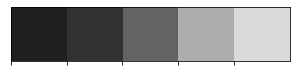

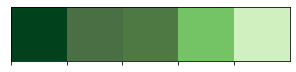

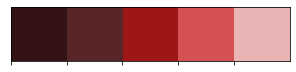

In [740]:
#Si definiscono array di colori che vengono raggruppati in scuri, rossi e verdi e utilizzati in seguito
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [742]:
#Percorsi sui quali è localizzato il dataset (serve per una successiva fase di testing)
Train_Data_Path = Path("./Desktop/terzo anno/tesi/Brain-Tumor-Classification-DataSet-master/Training")
Test_Data_Path = Path("./Desktop/terzo anno/tesi/Brain-Tumor-Classification-DataSet-master/Testing")
batch_size = 100

In [743]:
#Si crea una lista di path di immagini raggruppandole in training e testing
Train_JPG_Path = list(Train_Data_Path.glob(r"*/*.jpg"))
Test_JPG_Path = list(Test_Data_Path.glob(r"*/*.jpg"))

In [744]:
#Si fa uno split del pathname andando a prendere solamente la parte che ci indica a quale tipo di tumore l'immagine si riferisce
Train_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Train_JPG_Path))
Test_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Test_JPG_Path))

In [745]:
#Si contano le immagini a disposizione per il training
print("NO: ",Train_JPG_Labels.count("no_tumor"))
print("Pituitary: ",Train_JPG_Labels.count("pituitary_tumor"))
print("Meningioma: ",Train_JPG_Labels.count("meningioma_tumor"))
print("Glioma: ",Train_JPG_Labels.count("glioma_tumor"))

NO:  395
Pituitary:  827
Meningioma:  822
Glioma:  826


In [746]:
print(Test_Data_Path)

Desktop\terzo anno\tesi\Brain-Tumor-Classification-DataSet-master\Testing


In [747]:
#Si contano le immagini a disposizione per il testing
print("NO: ",Test_JPG_Labels.count("no_tumor"))
print("Pituitary: ",Test_JPG_Labels.count("pituitary_tumor"))
print("Meningioma: ",Test_JPG_Labels.count("meningioma_tumor"))
print("Glioma: ",Test_JPG_Labels.count("glioma_tumor"))

NO:  105
Pituitary:  74
Meningioma:  115
Glioma:  100


In [748]:
#Si va a creare un array di percorsi di immagini con accanto la label che indica la 
# categoria di tumore che si trova nell'immagine
Train_JPG_Path_Series = pd.Series(Train_JPG_Path,name="JPG").astype(str)
Train_JPG_Labels_Series = pd.Series(Train_JPG_Labels, name="TUMOR_CATEGORY")
Test_JPG_Path_Series = pd.Series(Test_JPG_Path,name="JPG").astype(str)
Test_JPG_Labels_Labels = pd.Series(Test_JPG_Labels,name="TUMOR_CATEGORY")

Main_Train_Data = pd.concat([Train_JPG_Path_Series,Train_JPG_Labels_Series],axis=1)
Main_Test_Data = pd.concat([Test_JPG_Path_Series,Test_JPG_Labels_Labels],axis=1)

In [749]:
#Si fa uno shuffle delle immagini (opzionale)
Main_Train_Data = Main_Train_Data.sample(frac=1).reset_index(drop=True)
Main_Test_Data = Main_Test_Data.sample(frac=1).reset_index(drop=True)

In [750]:
#Si semplificano i nomi dei tumori per una maggior comprensione
Main_Train_Data["TUMOR_CATEGORY"].replace({"glioma_tumor":"Glioma",
                                         "meningioma_tumor":"Meningioma",
                                         "no_tumor":"No",
                                         "pituitary_tumor":"Pituitary"},inplace=True)
Main_Test_Data["TUMOR_CATEGORY"].replace({"glioma_tumor":"Glioma",
                                         "meningioma_tumor":"Meningioma",
                                         "no_tumor":"No",
                                         "pituitary_tumor":"Pituitary"},inplace=True)

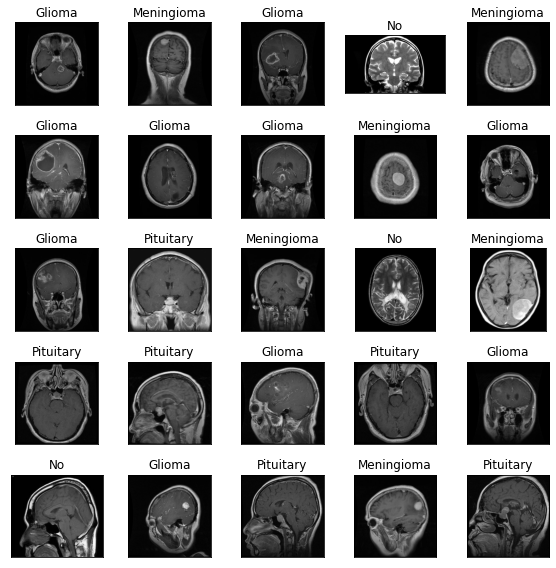

In [751]:
#Si generano un po' di campioni di immagini nel dataset
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Train_Data["JPG"][i+100*i]))
    ax.set_title(Main_Train_Data["TUMOR_CATEGORY"][i+100*i])
plt.tight_layout()
plt.show()



In [752]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


In [753]:
#Si iniziano a leggere tutte le immagini e ad aggiungerle tramite una lista
#e si convertono in un numpy array dopo averle rese tutte della stessa grandezza
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 150
for i in labels:
    folderPath = os.path.join('./Desktop/terzo anno/tesi/Brain-Tumor-Classification-DataSet-master','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('./Desktop/terzo anno/tesi/Brain-Tumor-Classification-DataSet-master','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 83.42it/s]


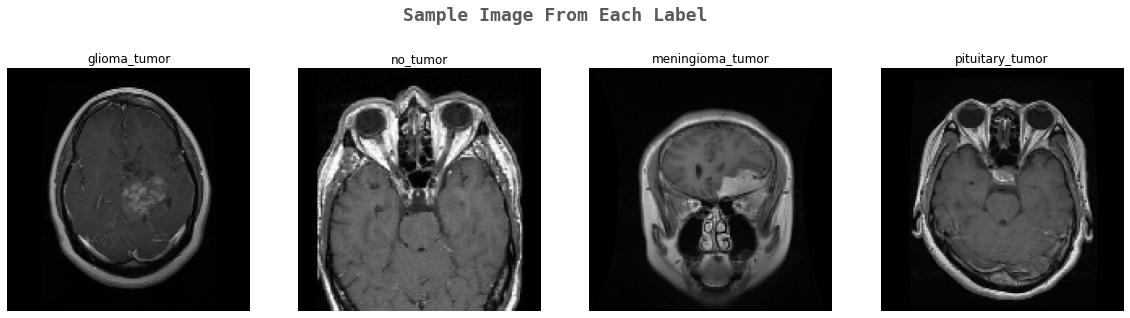

In [754]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [755]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [756]:
#Si può vedere come l'array X_train sia delle dimensioni impostate
X_train.shape

(2870, 150, 150, 3)

In [757]:
train_data,test_data = train_test_split(Main_Train_Data,train_size=0.9,random_state=42)

In [795]:
#Viene fatta Data Augmentation in quanto le dimensioni del dataset sono abbastanza ridotte.
#Per evitare underfitting (ma anche overfitting) è possibile andare ad ampliare artificialmente il data set creando versioni modificate delle
#immagini del dataset stesso. Si utilizzano tecniche come il flipping, lo zooming, il padding, il cropping, il riscaling... 
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)


X_train.shape

test_data_gen = ImageDataGenerator(rescale = 1./255,
                                rotation_range=30,
                                zoom_range = 0.2,
                                width_shift_range=0.1,  
                                height_shift_range=0.1,
                                  horizontal_flip=True)
test_data_gen.fit(X_test)

image_gen_val = ImageDataGenerator(rescale=1./255)
X_test.shape

(394, 150, 150, 3)

In [796]:
train = datagen.flow_from_directory('./Desktop/terzo anno/tesi/Brain-Tumor-Classification-DataSet-master/Training',
                                  target_size=(image_size, image_size),
                                  color_mode='rgb',
                                  class_mode='categorical',
                                  save_to_dir = 'C:/Users/franc/Desktop/terzo anno/tesi/Brain-Tumor-Classification-DataSet-master/augmented',
                                  batch_size=batch_size,
                                  shuffle = True,
                                   subset="training")

valid = image_gen_val.flow_from_directory('./Desktop/terzo anno/tesi/Brain-Tumor-Classification-DataSet-master/Testing',
                                    target_size=(image_size, image_size),
                                    color_mode="rgb",
                                    save_to_dir = 'C:/Users/franc/Desktop/terzo anno/tesi/Brain-Tumor-Classification-DataSet-master/augmented',
                                    class_mode="categorical",
                                    batch_size=batch_size,
                                    shuffle = False)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [610]:
print(train_data.shape)

(2583, 2)


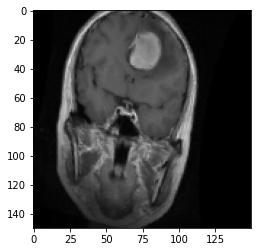

In [694]:
augmented_images = [train[0][0][0] for i in range(5)]
for i in range(4):
    plt.imshow(augmented_images[i])

In [772]:
Train_Set = datagen.flow_from_dataframe(dataframe=train_data,
                                         x_col="JPG",
                                         y_col="TUMOR_CATEGORY",
                                         seed=42,
                                          color_mode="rgb",
                                         class_mode="categorical",
                                          batch_size=batch_size,
                                         subset="training"
                                         )
Validation_Set = datagen.flow_from_dataframe(dataframe=test_data,
                                              x_col="JPG",
                                              y_col="TUMOR_CATEGORY",
                                              seed=42,
                                               color_mode="rgb",
                                              class_mode="categorical",
                                              batch_size=batch_size,
                                              )
Test_Set = datagen.flow_from_dataframe(dataframe=test_data,
                                              x_col="JPG",
                                              y_col="TUMOR_CATEGORY",
                                              seed=42,
                                               color_mode="rgb",
                                              class_mode="categorical",
                                              batch_size=16
                                              )

Found 2583 validated image filenames belonging to 4 classes.
Found 287 validated image filenames belonging to 4 classes.
Found 287 validated image filenames belonging to 4 classes.


In [708]:
#Si divide tutto il dataset in training e testing. L'array X mi serve per contenere le immagini, 
#mentre y salva la categoria di tumore associato all'immagine stessa
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [709]:

#from sklearn.model_selection import train_test_split
#X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=.3)

#print((X_train.shape,y_train.shape))
#print((X_val.shape,y_val.shape))
#print((X_test.shape,y_test.shape))
# X_test forms the test images, and y_test forms the test labels


In [614]:
#Per la classificazione è necessario utilizzare una codifica di tipo One-Hot,
#tutti gli elementi di y pertanto diventano codificati in questo modo
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [710]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.regularizers import l2

In [727]:
#Si definisce il modello per fare il training della rete neurale. 
#Si utilizzano 4 strati di convoluzione intervallati da fasi di Max-Pooling. 
#Si utilizza la relu come funzione di attivazione e dei filtri di dimensione 3x3. 
#Successivamente si va a fare un flattening dell'input e da CNN si passa ad ANN.
#Si utilizza una dimensione extra none che serve in quanto la batch_size può variare.
#Con gli strati Dense si va a lavorare con una rete fully-connected come nelle ANN semplici.
#La classificazione usa la funzione softmax, perchè permette di fare previsioni 
#per più di due categorie
cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation="relu", input_shape=(image_size, image_size, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation="relu", input_shape=(image_size, image_size, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation="relu", input_shape=(image_size, image_size, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation="relu", input_shape=(image_size, image_size, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation="relu", input_shape=(image_size, image_size, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())
cnn.add(Dense(kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation = 'relu', units = 128))
cnn.add(Dense(kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation = 'relu', units = 64))
cnn.add(Dense(kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation = 'softmax', units = 4))
cnn.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [728]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 0.8686440677966102, 1: 0.8728710462287105, 2: 1.8164556962025316, 3: 0.8675937122128174}


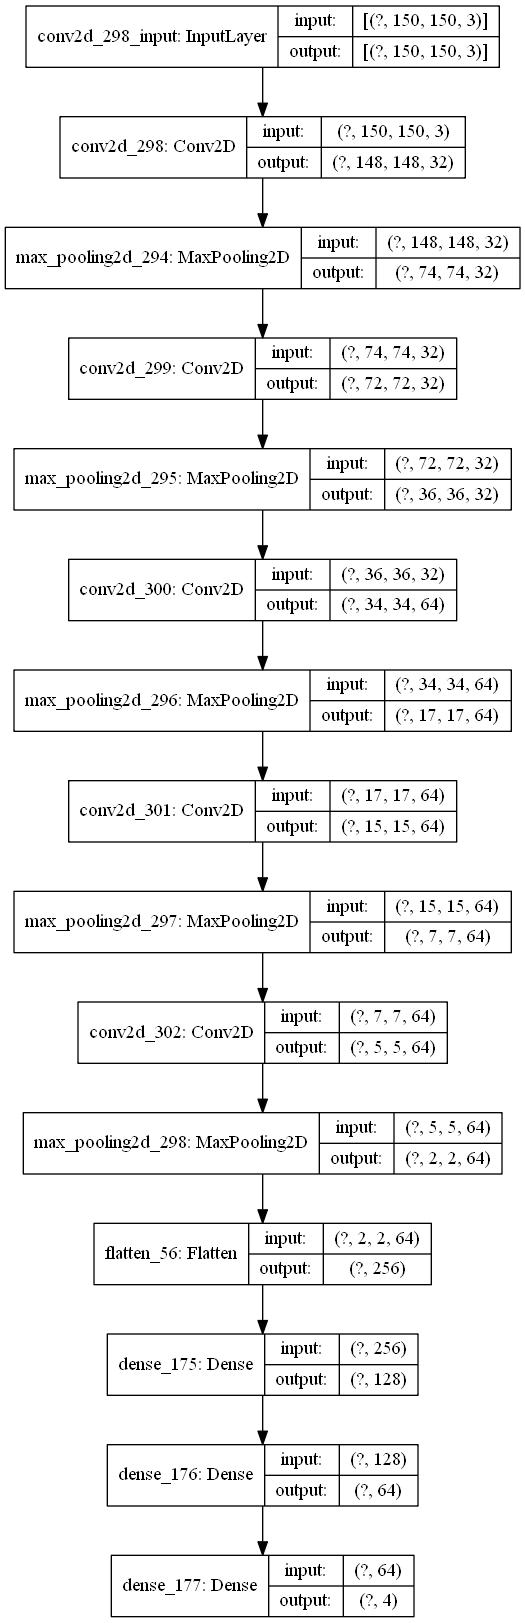

In [729]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [714]:
#early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',  verbose=1,factor=0.3, min_lr=0.0001)
#callbacks_list = [ early, learning_rate_reduction]

In [715]:
cnn.summary()

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_293 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_289 (MaxPoolin (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_294 (Conv2D)          (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_290 (MaxPoolin (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_295 (Conv2D)          (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_291 (MaxPoolin (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_296 (Conv2D)          (None, 15, 15, 64)      

In [672]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

In [673]:

#%reload_ext tensorboard

#import tensorflow as tf
#import datetime

#%tensorboard --logdir logs//fit


In [797]:
#fase di fitting
STEP_SIZE_TRAIN=train.n//train.batch_size
STEP_SIZE_VALID=valid.n//valid.batch_size
history = cnn.fit(train, validation_data = valid, steps_per_epoch=STEP_SIZE_TRAIN, epochs =25, validation_steps=STEP_SIZE_VALID, verbose=1,
                   callbacks=[tensorboard,checkpoint, learning_rate_reduction])

Epoch 1/25
28/28 [==============================] - ETA: 0s - loss: 1.0417 - accuracy: 0.6415
Epoch 00001: val_accuracy did not improve from 0.35533
28/28 [==============================] - 112s 4s/step - loss: 1.0417 - accuracy: 0.6415 - val_loss: 2.3025 - val_accuracy: 0.2333
Epoch 2/25
28/28 [==============================] - ETA: 0s - loss: 1.0500 - accuracy: 0.6415
Epoch 00002: val_accuracy did not improve from 0.35533
28/28 [==============================] - 112s 4s/step - loss: 1.0500 - accuracy: 0.6415 - val_loss: 2.1174 - val_accuracy: 0.2267
Epoch 3/25
28/28 [==============================] - ETA: 0s - loss: 1.0481 - accuracy: 0.6397
Epoch 00003: val_accuracy did not improve from 0.35533
28/28 [==============================] - 109s 4s/step - loss: 1.0481 - accuracy: 0.6397 - val_loss: 2.2744 - val_accuracy: 0.2500
Epoch 4/25
28/28 [==============================] - ETA: 0s - loss: 1.0453 - accuracy: 0.6361
Epoch 00004: val_accuracy did not improve from 0.35533
28/28 [=======

KeyboardInterrupt: 

<AxesSubplot:>

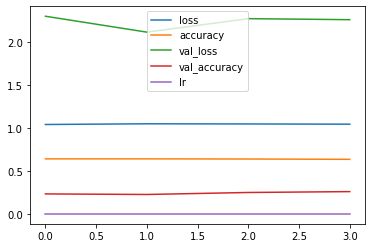

In [798]:
pd.DataFrame(cnn.history.history).plot()

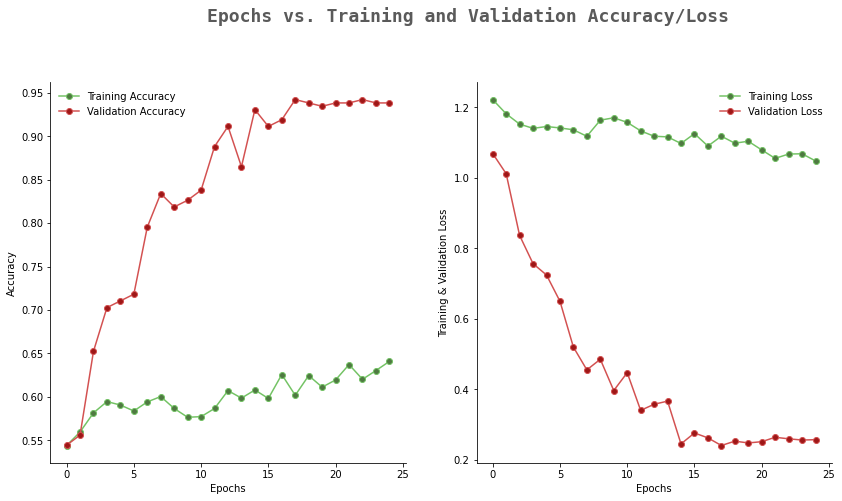

In [778]:
#Andamento dell'accuracy e della perdita (loss) durante il training della rete

filterwarnings('ignore')

epochs = [i for i in range(25)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
#val_acc = history.history['val_accuracy']
#val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [834]:
#Si fanno delle previsioni
pred = cnn.predict(test)
pred = np.argmax(pred,axis=1)
#y_test_new = np.argmax(y_test,axis=1)

In [835]:
Predict_Label = (Main_Test_Set.class_indices)
Predict_Label = dict((v,k) for k,v in Predict_Label.items())

In [836]:
pred = [Predict_Label[k] for k in pred]

In [837]:
Test_Results = list(Main_Test_Data["TUMOR_CATEGORY"])

In [838]:
Class_Report = classification_report(Test_Results,pred)
print(Class_Report)

              precision    recall  f1-score   support

      Glioma       0.33      0.07      0.12       100
  Meningioma       0.28      0.36      0.31       115
          No       0.27      0.49      0.35       105
   Pituitary       0.19      0.09      0.13        74

    accuracy                           0.27       394
   macro avg       0.27      0.25      0.23       394
weighted avg       0.27      0.27      0.24       394



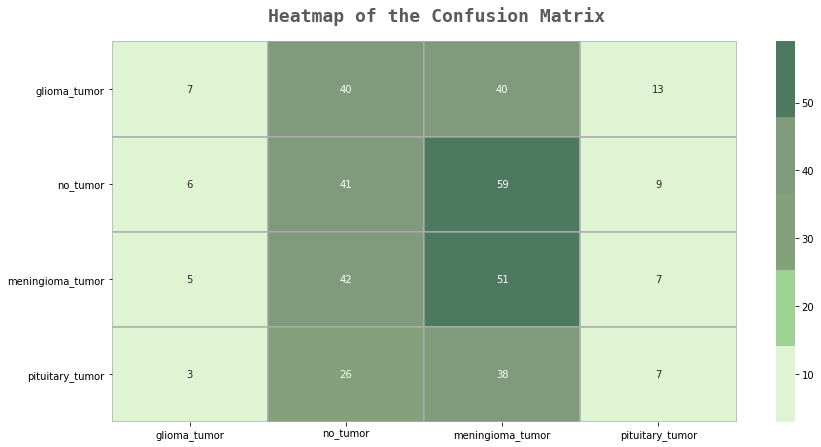

In [841]:
#Si utilizza una matrice di confusione per andare a vedere in ogni casella il valore di probabilità 
#per cui quel tumore viene effettivamente riconosciuto come tale

fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(Test_Results,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [842]:
#si vede se effettivamente caricando una determinata immagine dal set di testing, 
#questa venga riconosciuta in maniera corretta
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = cnn.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [843]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [844]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

In [845]:
#La parte successiva serve a visualizzare i risultati su un set di immagini prese casualmente

In [846]:
Main_Test_Set = datagen.flow_from_dataframe(dataframe=Main_Test_Data,
                                              x_col="JPG",
                                              y_col="TUMOR_CATEGORY",
                                              seed=42,
                                               color_mode="rgb",
                                              class_mode="categorical",
                                              batch_size=25
                                                 )

Found 394 validated image filenames belonging to 4 classes.


In [847]:
print(Main_Test_Set)

In [848]:
#shuffling
Main_Train_Data = Main_Train_Data.sample(frac=1).reset_index(drop=True)
Main_Test_Data = Main_Test_Data.sample(frac=1).reset_index(drop=True)

In [849]:
p = cnn.predict(X_test)

In [850]:
Model_Predict = np.argmax(p,axis=1)

In [851]:
print(Model_Predict)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 1 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 2 1 1 2 2 2 2 2 2 2 1 2 2 2 1 1 2 2 2 1 2
 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 1 2 1 1 1 2 2 2
 2 2 2 2 1 2 2 1 1 2 1 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 1 2 1 2 2 2 2 2
 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 1 1 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [852]:
Predict_Label = (Main_Test_Set.class_indices)
Predict_Label = dict((v,k) for k,v in Predict_Label.items())

In [820]:
print(Predict_Label)

{0: 'Glioma', 1: 'Meningioma', 2: 'No', 3: 'Pituitary'}


In [821]:
Model_Predict = [Predict_Label[k] for k in Model_Predict]

In [822]:
print(Model_Predict)

['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Meningioma', 'Meningioma', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Meningioma', 'No', 'Meningioma', 'No', 'No', 'Meningioma', 'No', 'No', 'No', 'No', 'Meningioma', 'Meningioma', 'Meningioma', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Meningioma', 'No', 'No', 'No', 'Meningioma', 'No', 'No', 'Meningioma', 'Meningioma', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Meningioma', 'No', 'No', 'No', 'Meningioma', 'Meningioma', 'No', 'No', 'No', 'Meningioma', 'No', 'No', 'Meningioma', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Meningioma', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Meningioma', 'No', 'No', 'No', 'Mening

In [823]:
print(Model_Predict[70:110])

['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Meningioma', 'No', 'No', 'No', 'Meningioma', 'No', 'No', 'Meningioma', 'Meningioma', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Meningioma', 'No', 'No', 'No', 'Meningioma', 'Meningioma', 'No', 'No', 'No', 'Meningioma']


In [824]:
Test_Results = list(Main_Test_Data["TUMOR_CATEGORY"])


In [825]:
print(Test_Results)

['Glioma', 'No', 'Glioma', 'Pituitary', 'No', 'Meningioma', 'Glioma', 'No', 'Pituitary', 'Meningioma', 'Glioma', 'Glioma', 'No', 'Glioma', 'No', 'Pituitary', 'Meningioma', 'Meningioma', 'Meningioma', 'Glioma', 'Pituitary', 'Pituitary', 'Pituitary', 'Glioma', 'Glioma', 'Meningioma', 'Meningioma', 'Meningioma', 'Glioma', 'No', 'Meningioma', 'Pituitary', 'Meningioma', 'No', 'Glioma', 'No', 'Meningioma', 'Meningioma', 'Glioma', 'No', 'Glioma', 'Glioma', 'Pituitary', 'Meningioma', 'Pituitary', 'Pituitary', 'Meningioma', 'No', 'Glioma', 'Glioma', 'Meningioma', 'Pituitary', 'Meningioma', 'No', 'Meningioma', 'Pituitary', 'Pituitary', 'Meningioma', 'No', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Meningioma', 'Glioma', 'No', 'No', 'Meningioma', 'No', 'Meningioma', 'Meningioma', 'Glioma', 'Meningioma', 'No', 'Meningioma', 'Glioma', 'Glioma', 'Meningioma', 'Meningioma', 'Meningioma', 'Meningioma', 'Meningioma', 'Meningioma', 'No', 'No', 'Meningioma', 'Meningioma', 'Meningioma', 'Glioma', 'Meningiom

In [60]:
from tensorflow.keras.preprocessing import image



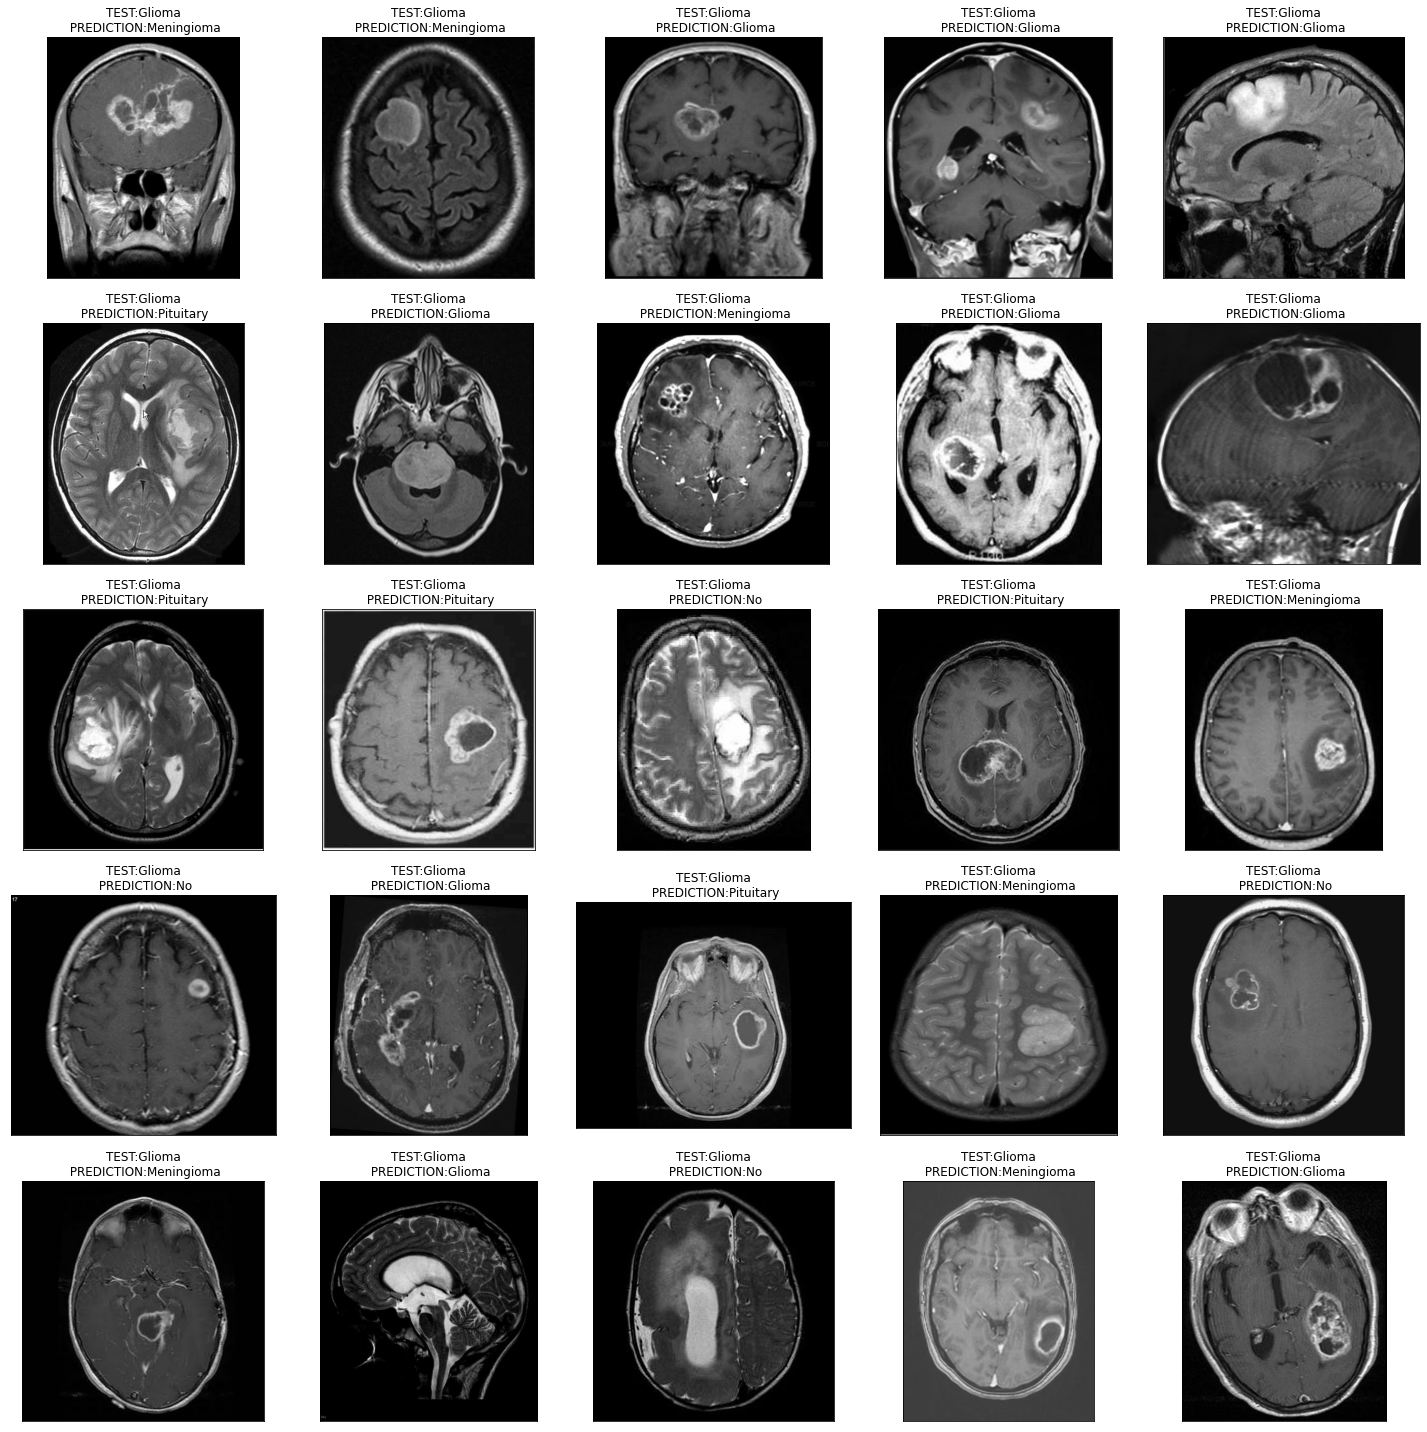

In [61]:
fig, axes = plt.subplots(nrows=5,
                         ncols=5,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Test_Data["JPG"].iloc[2*i]))
    ax.set_title(f"TEST:{Test_Results[2*i]}\n PREDICTION:{Model_Predict[2*i]}")
plt.tight_layout()
plt.show()